In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class QueueMM2():
    def __init__(self, lbd, mu, cap=5):

        self.lbd = lbd                        # каждые lambda минут поступает новое требование
        self.mu = mu                          # время обслуживания на сервере 1/mu
        self.cap = cap                        # max capacity of queue

        self.clock = 0.0                      # simulation clock
        self.queue_length = 0                 # current number in queue
        self.next_arriv_time = self.gen_arrival_time() # time of next arrival

        self.leaving_time1 = float('inf')     # departure time from server 1
        self.leaving_time2 = float('inf')     # departure time from server 2

        self.S1_state = 0                     # current state of server 1 (0-free, 1-busy)
        self.S2_state = 0                     # current state of server 2 (0-free, 1-busy)

        self.num_of_departures1 = 0           # number of customers served by server 1
        self.num_of_departures2 = 0           # number of customers served by server 2

        self.sum_serv_times1 = 0              # sum of service times by server 1
        self.sum_serv_times2 = 0              # sum of service times by server 2

        self.num_arrivals = 0                 # number of arrivals
        self.lost_customers = 0               # number of customers who left without service
        self.waiting_customers = 0            # number of customers who wait in queue
        self.system_inaction = 0              # time when both servers are free and queue is empty
        self.customers_in_queue_per_iter = [] # number of customers in queue per iteration

    def time_adv(self):
        t_next_event = min(self.next_arriv_time, self.leaving_time1, self.leaving_time2)
        self.clock = t_next_event
        if self.next_arriv_time < self.leaving_time1 and self.next_arriv_time < self.leaving_time2:
            self.Arrival()
        elif self.next_arriv_time > self.leaving_time1 and self.leaving_time1 < self.leaving_time2:
            self.Server1()
        else:
            self.Server2()
        self.customers_in_queue_per_iter.append(self.queue_length)

    def Arrival(self):
        self.num_arrivals += 1

        if self.queue_length == 0: #schedule next departure or arrival depending on state of servers

            if self.S1_state == 1 and self.S2_state == 1: # -> customer waits in queue
                self.queue_length += 1

            elif self.S1_state == 0 and self.S2_state == 0: # -> customer goes to 1st or 2nd server
                self.system_inaction += 1

                if (np.random.choice([1, 2]) == 1): # -> customer goes to 1st server, 2nd is free
                    self.S1_state = 1
                    self.service_time1 = self.gen_service_time()
                    self.sum_serv_times1 += self.service_time1
                    self.leaving_time1 = self.clock + self.service_time1
                else: # -> customer goest to 2nd server, 1st if free
                    self.S2_state = 1
                    self.service_time2 = self.gen_service_time()
                    self.sum_serv_times2 += self.service_time2
                    self.leaving_time2 = self.clock + self.service_time2

            elif self.S1_state == 0 and self.S2_state == 1: # -> customer goes to 1st server
                self.S1_state = 1
                self.service_time1 = self.gen_service_time()
                self.sum_serv_times1 += self.service_time1
                self.leaving_time1 = self.clock + self.service_time1
            else: # -> customer goes to 2nd server
                self.S2_state = 1
                self.service_time2 = self.gen_service_time()
                self.sum_serv_times2 += self.service_time2
                self.leaving_time2 = self.clock + self.service_time2

        elif self.queue_length < self.cap: # -> generate next arrival and make customer join queue
            self.queue_length += 1
            self.waiting_customers += 1
        else: # -> customer goes away
            self.lost_customers += 1
        
        self.next_arriv_time = self.clock + self.gen_arrival_time()

    def Server1(self): # departure from server 1
        self.num_of_departures1 += 1
        if self.queue_length > 0:
            self.service_time1 = self.gen_service_time()
            self.sum_serv_times1 += self.service_time1
            self.leaving_time1 = self.clock + self.service_time1
            self.queue_length -= 1
        else:
            self.leaving_time1 = float('inf')
            self.S1_state = 0

    def Server2(self): # departure from server 2
        self.num_of_departures2 += 1
        if self.queue_length > 0:
            self.service_time2 = self.gen_service_time()
            self.sum_serv_times2 += self.service_time2
            self.leaving_time2 = self.clock + self.service_time2
            self.queue_length -= 1
        else:
            self.leaving_time2 = float('inf')
            self.S2_state = 0

    def gen_arrival_time(self): # generates arrival times using poisson distribution
        return (np.random.poisson(self.lbd))

    def gen_service_time(self): # generates service time for servers using exponential distribution
        return (np.random.exponential(1./self.mu))

    ## calculate metrics ##

    def get_avg_time_in_system(self):
        return np.round(self.clock / self.num_arrivals, 4)

    def get_prob_of_non_serving(self):
        return np.round(self.lost_customers / self.num_arrivals, 4)

    def get_prob_of_waiting(self):
        return np.round(self.waiting_customers / self.num_arrivals, 4)

    def get_avg_customers_count_in_queue(self):
        return np.mean(self.customers_in_queue_per_iter)

    def get_prob_of_system_inaction(self):
        return np.round(self.system_inaction / self.clock, 4) 

In [3]:
df = pd.DataFrame(columns=['Average interarrival time', 'Average service time server 1',
                           'Average service time server 2', 'Lost Customers', 'Queue length'])

for i in range(100):
    np.random.seed(i)
    system = QueueMM2(lbd=0.5, mu=2)
    while system.clock <= 1000:
        system.time_adv()

    statistics = pd.Series([system.clock / system.num_arrivals,
                            system.sum_serv_times1 / system.num_of_departures1,
                            system.sum_serv_times2 / system.num_of_departures2,
                            system.lost_customers,
                            system.queue_length], index=df.columns)
    df = df.append(statistics, ignore_index=True)

df.to_excel('results.xlsx')

In [4]:
df

,Average interarrival time,Average service time server 1,Average service time server 2,Lost Customers,Queue length
0,0.511740,0.500487,0.507221,88.0,3.0
1,0.505838,0.503798,0.500110,112.0,2.0
2,0.491008,0.460656,0.489531,122.0,0.0
3,0.489391,0.543865,0.515884,143.0,0.0
4,0.535363,0.506288,0.500902,57.0,2.0
...,...,...,...,...,...
95,0.509206,0.464236,0.518218,78.0,0.0
96,0.507671,0.518201,0.511270,102.0,0.0
97,0.543278,0.502144,0.504433,83.0,1.0
98,0.484075,0.495880,0.498304,137.0,2.0


# Эксперименты с различными параметрами
В ходе экспериментов будем вычислять следующие метрики:
 - Среднее время пребывания требования в системе
 - Вероятность отказа (требование пришло, а очередь заполнена)
 - Вероятность ожидания (требование пришло, а очередь непустая)
 - Среднее количество заявок в очереди
 - Вероятность простоя системы (оба сервера свободны и очередь пустая)

In [5]:
metrics_titles = ['Average time in the system',
                  'Probabily of non-serving',
                  'Probability of waiting',
                  'Average count of customers in queue',
                  'Probability of system inaction']

In [6]:
def run_mm2_queue(lbd, mu, cap, n_iter, seed=42):
    np.random.seed()
    system = QueueMM2(lbd, mu, cap)

    for i in range(n_iter):
        system.time_adv()

    metrics = {
        'avg_time_in_system': system.get_avg_time_in_system(),
        'prob_of_non_serving': system.get_prob_of_non_serving(),
        'prob_of_waiting': system.get_prob_of_waiting(),
        'avg_customers_count_in_queue': system.get_avg_customers_count_in_queue(),
        'prob_of_system_inaction': system.get_prob_of_system_inaction()
    }

    params = {
        'Lambda': lbd,
        'Mu': mu,
        'Rough': lbd/(2*mu),
        'Arrived customers': system.num_arrivals
    }
    
    return metrics

In [7]:
def draw_metrics(params, test_metrics, param_name):
    plt.figure(figsize=(15,15))
    plt.suptitle(f'Метрики в зависимости от параметра {param_name}')

    i = 0

    for metric_name, values in test_metrics.items():
        plt.subplot(321+i)   
        plt.plot(params, values, 'o-')
        plt.title(metrics_titles[i])
        plt.xlabel(param_name)
        plt.ylabel(metric_name)
        plt.tight_layout()
        plt.grid()
        i += 1

    plt.show()

## 1. Рассмотрим случай для $\lambda \leq \mu$

Будем менять $\lambda$ и зафиксируем $\mu=3$.

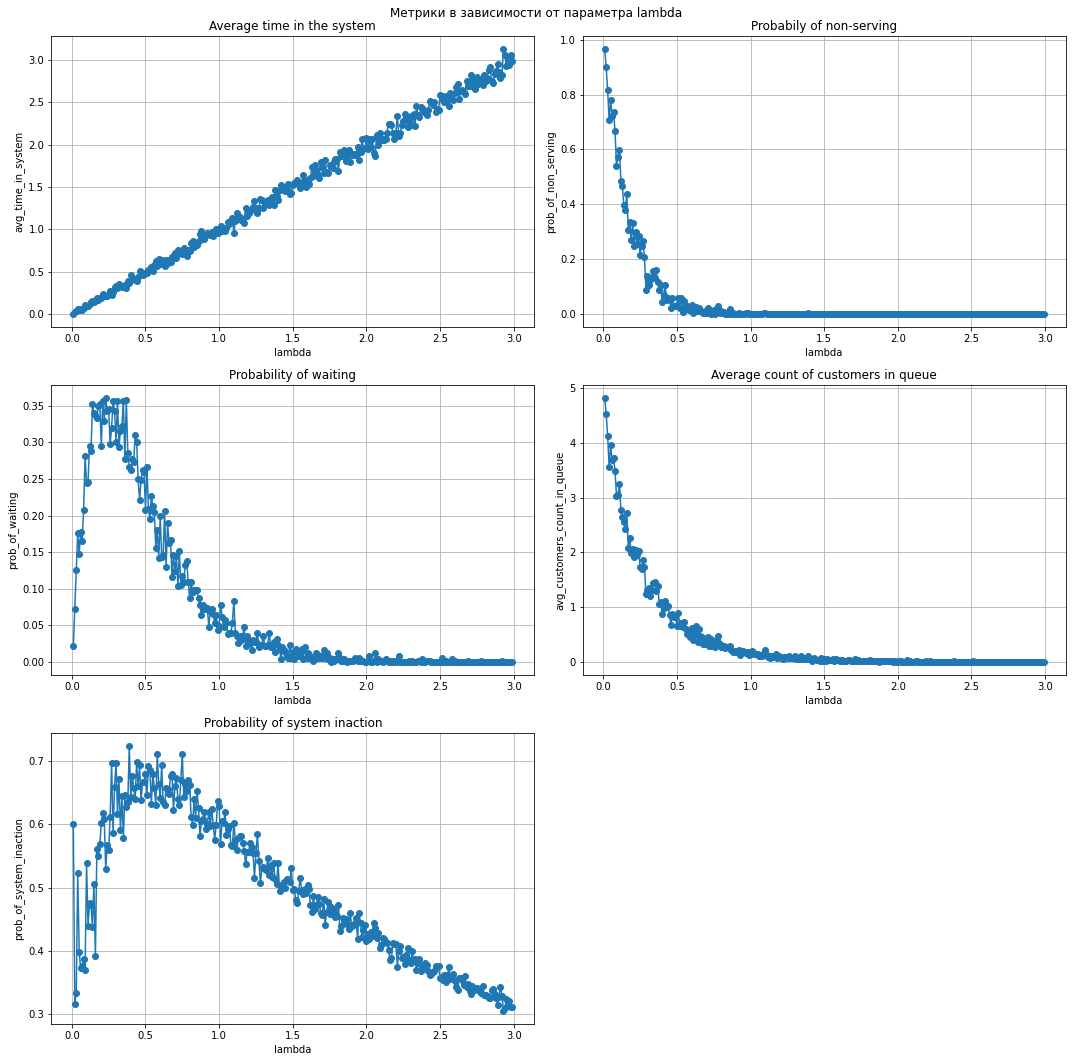

In [8]:
mu = 3
int_size = 0.01
lambdas = np.arange(0.01, mu, int_size)
capacity = 5

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list(),
    'prob_of_system_inaction': list()
}

for lbd in lambdas:
    metrics = run_mm2_queue(lbd, mu, capacity, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])
    test_metrics['prob_of_system_inaction'].append(metrics['prob_of_system_inaction'])
    
draw_metrics(lambdas, test_metrics, 'lambda')

Теперь будем менять $\mu$ и зафиксируем $\lambda=0.1$.

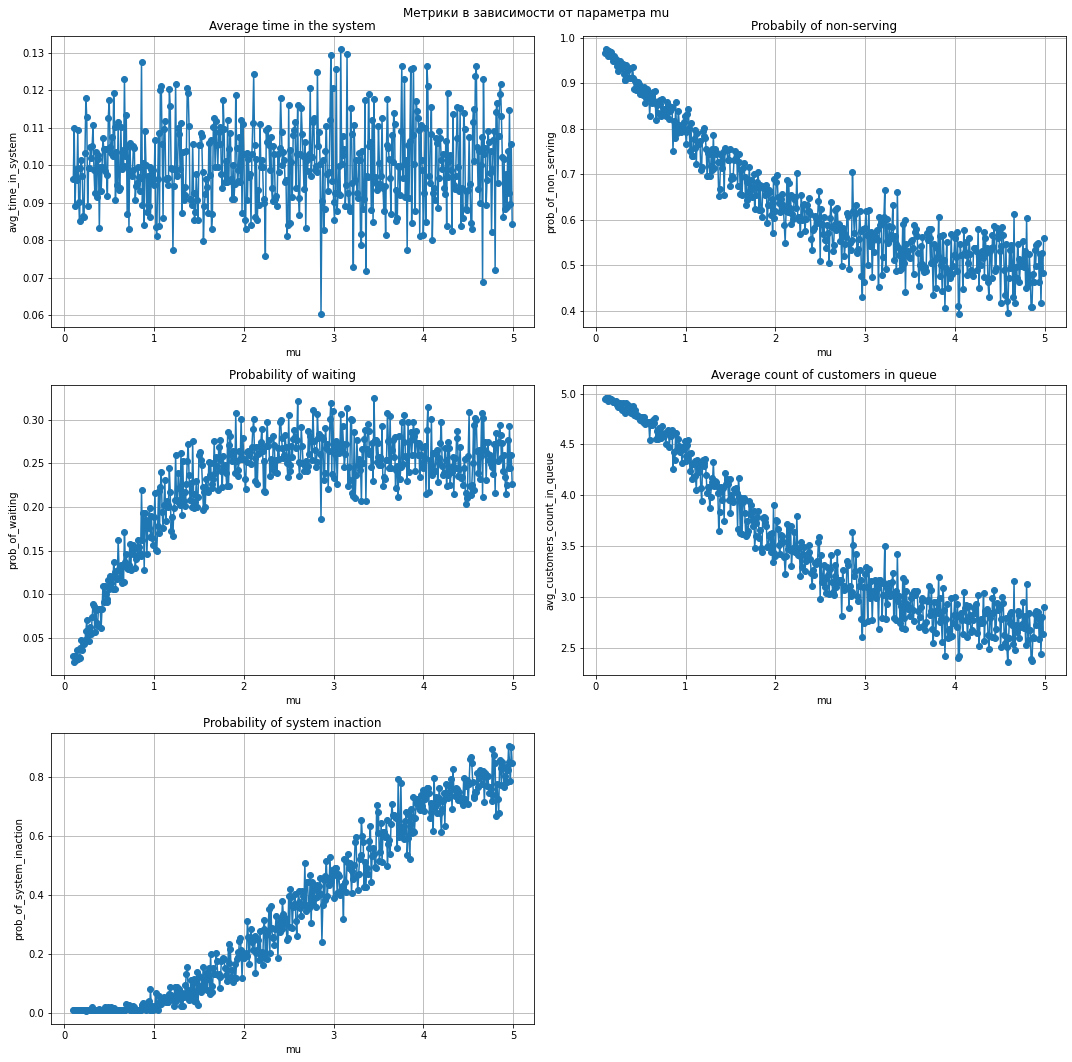

In [10]:
mu_array = np.arange(0.1, 5, 0.01)
lbd = 0.1
capacity = 5

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list(),
    'prob_of_system_inaction': list()
}

for mu in mu_array:
    metrics = run_mm2_queue(lbd, mu, capacity, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])
    test_metrics['prob_of_system_inaction'].append(metrics['prob_of_system_inaction'])
    
draw_metrics(mu_array, test_metrics, 'mu')

Зафиксируем $\mu, \lambda$ и посмотрим, как меняются графики при изменении размера очереди.

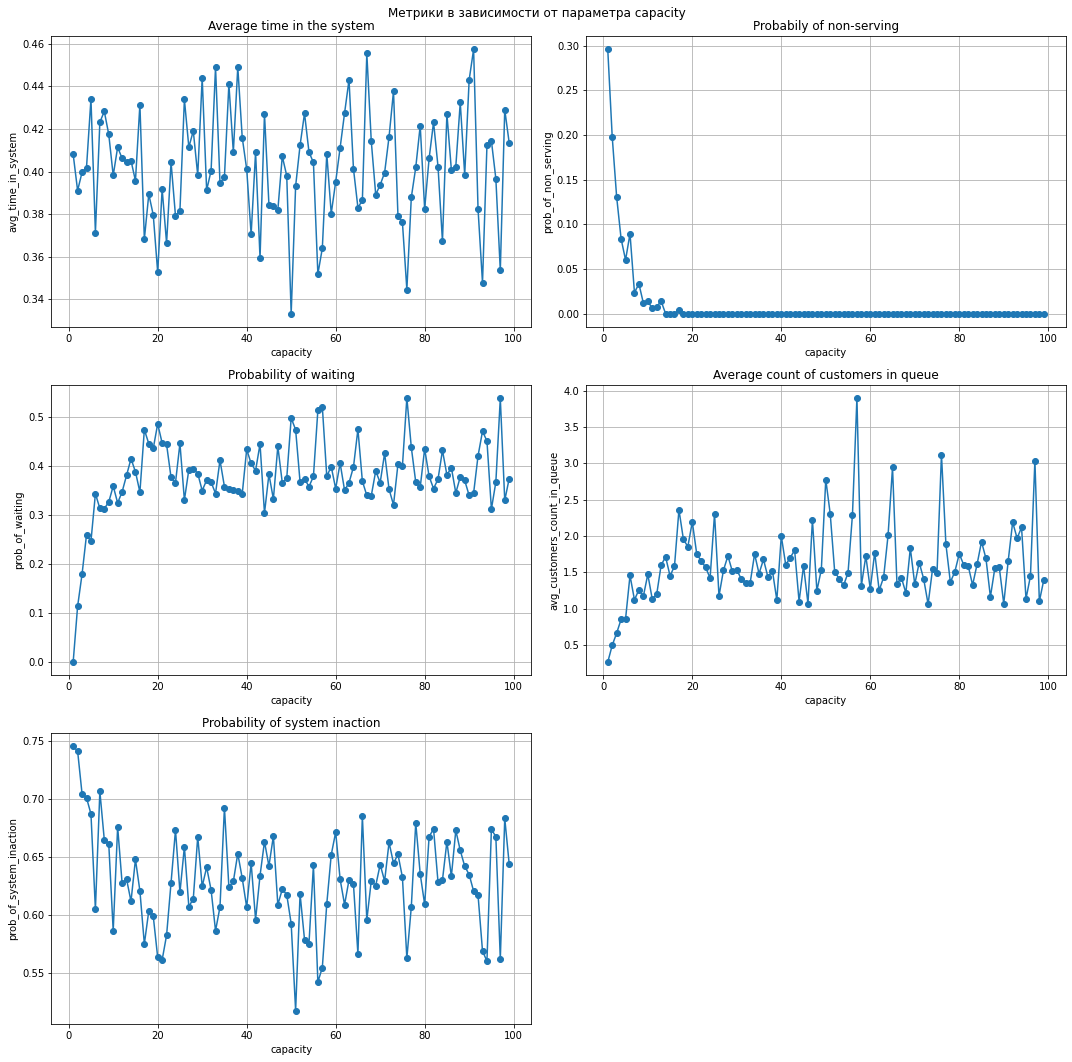

In [11]:
mu = 3
lmd = 0.4
capacity = np.arange(1, 100)

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list(),
    'prob_of_system_inaction': list()
}

for cap in capacity:
    metrics = run_mm2_queue(lmd, mu, cap, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])
    test_metrics['prob_of_system_inaction'].append(metrics['prob_of_system_inaction'])

draw_metrics(capacity, test_metrics, 'capacity')

## 2. Рассмотрим случай для $\lambda > \mu$
Зафиксируем $\mu=3$, меняем $\lambda$

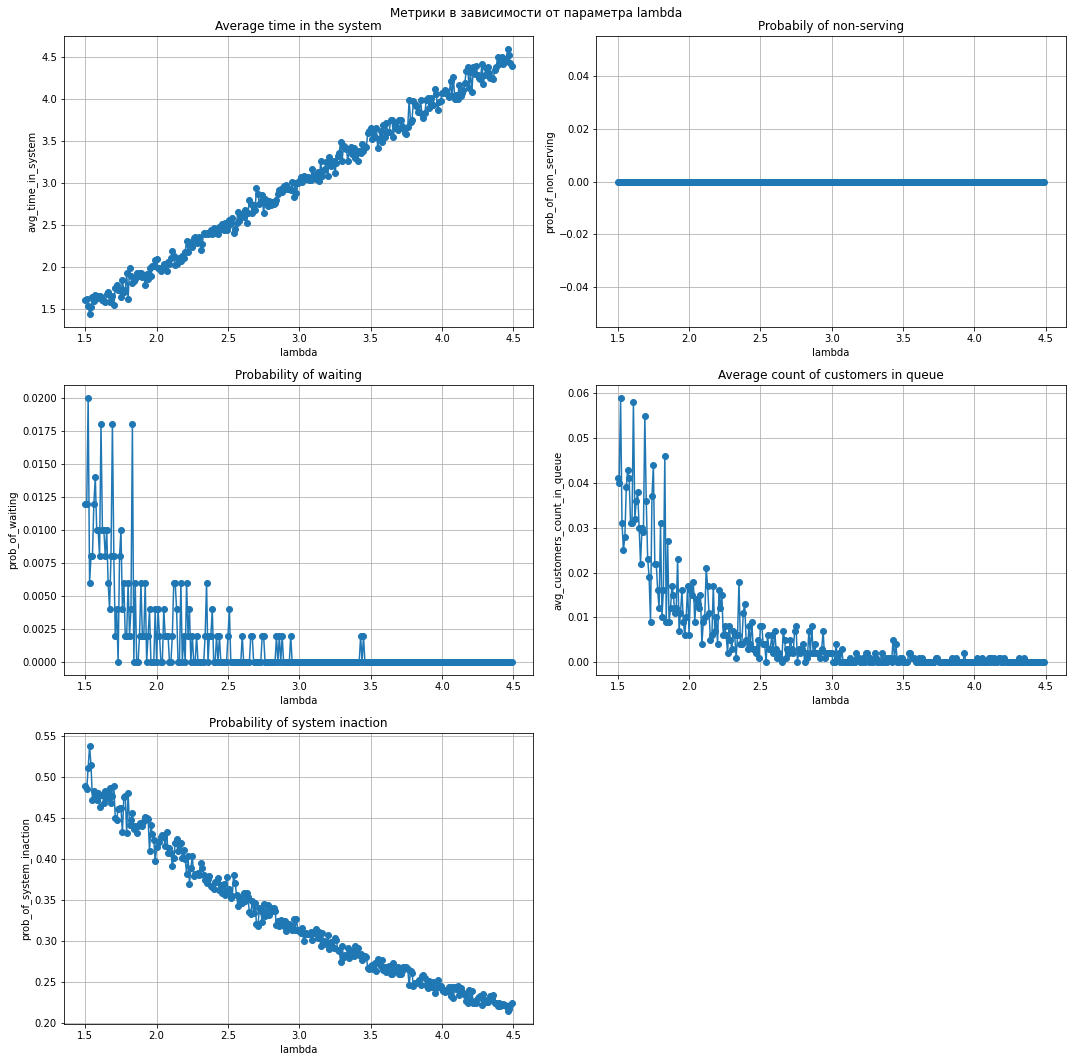

In [12]:
mu = 3
int_size = 0.01
lambdas = np.arange(mu/2, 3*mu/2, int_size)
capacity = 5

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list(),
    'prob_of_system_inaction': list()
}

for lbd in lambdas:
    metrics = run_mm2_queue(lbd, mu, capacity, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])
    test_metrics['prob_of_system_inaction'].append(metrics['prob_of_system_inaction'])

draw_metrics(lambdas, test_metrics, 'lambda')

Зафиксируем $\lambda=2$, меняем $\mu$

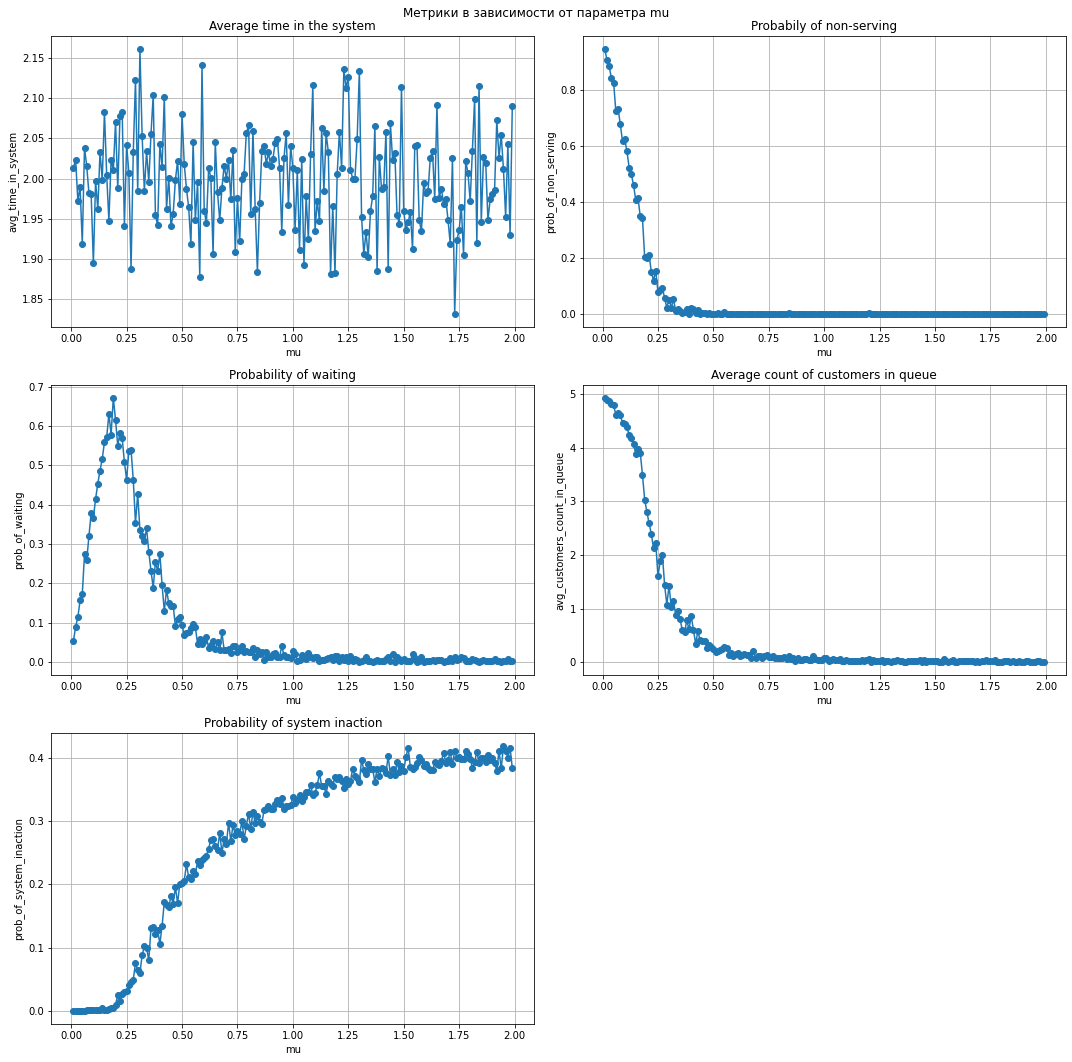

In [13]:
mu_array = np.arange(0.01, 2, 0.01)
int_size = 0.01
lbd = 2
capacity = 5

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list(),
    'prob_of_system_inaction': list()
}

for mu in mu_array:
    metrics = run_mm2_queue(lbd, mu, capacity, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])
    test_metrics['prob_of_system_inaction'].append(metrics['prob_of_system_inaction'])


draw_metrics(mu_array, test_metrics, 'mu')